# Speech Recognition

I imported the data and created an empirical transition matrix, which is also the maximum likelihood estimate for the transition matrix that produced the data. 

In [192]:
#importing speech files
import glob
import os
import numpy as np
def upload_file(path):
    file_list = glob.glob(os.path.join(os.getcwd(), path))
    corpus = []
    for file_path in file_list:
        with open(file_path) as f:
            corpus.append(f.read())
    return corpus

def make_markov_table(language_data):
    letters = list(set(language_data[0]))
    #alphabet of the data set
    transition = np.zeros((len(letters),len(letters))) 
    #transition table initialization
    start = np.zeros((len(letters),))
    #counting the starting letters for marginal distribution
    
    #Create transition matrix
    for s in range(len(language_data)): #per test string
        for idx in range(len(language_data[s]) - 1): #per character
            for i in range(len(letters)): 
                if language_data[s][idx] == letters[i]:
                    start[i] += 1
                    for j in range(len(letters)):
                        if language_data[s][idx+1] == letters[j]:
                            transition[i][j] += 1 
                            #add each consecutive character pair to table
    transition = transition / transition.sum(axis=1)[:, None]
    start = start / start.sum()
    return start, transition
            

In [193]:
langA = upload_file("symbol/language-training-langA*")
langB = upload_file("symbol/language-training-langB*")
langC = upload_file("symbol/language-training-langC*")
test = upload_file("symbol/language-test*")
print test

['pppooootgAookggggtttopAtttkkkeeggeeeeAAAgtkoAkkkkkooppppttppppppgppteoooooottkttttkkkktAAApgookkkkkp', 'gooooAAAAAAAAAkkkkkkooooAAAeppppppgeeeeepAAppeektetttgggogptttttttkppAAAApetAeegggtttteetttttppAAAAA', 'ekogoAgkepokogoppAttpAttgeekApegepApotpAAtpetgAtpopAttpAppAtkokettkgAttggokoogApppepogeApopogetpokog', 'AtAgegegegAgegetoAtetAogAooAoeAtegAgeotAoAgoetAteAteoegoeogetekoAoegAoegAtegAgeotAtAoAtetAtgeggAtAto', 'popoktgopogettpegAtkegotkogettpApepApegtgApeogokokApetkAgegokpepketpotttpAtkopepototpApettgotokotgok', 'okopottogttpetgopopotkepeppAgAgetpotpAtgookettgoketkokAgAttpgopAgtkAggAgekottgokAkopApAkopAtgtttpokp', 'kteoeoeoAoteoAgeoetoegAgeoekgeteoegetetAgeAoAttAtAteoAtetotAoAoeooegegAoetgeoAtegtAteteoAtAgegAgeAoA', 'tgAkoggAggAtpetkpAgegAgkepepookepepekogokogetkekekekegegotgekAAkoAtpottktkApAgtpegAkAgAkpopettgApogA', 'oeeoppppppoooAgggggoAAoookkppeoAApeoAkAAAAAAApkpppgpppkkkkAAAAkkkkeeepeeeeeekktppppkeegggoooooooooAA', 'ApgotgAApogotgopAgegAtkAgketgAtkpAgottpopopAgpekepokpAokettttp

In [194]:
startA, transitionA = make_markov_table(langA)
startB, transitionB = make_markov_table(langB)
startC, transitionC = make_markov_table(langC)

In [198]:
letters = list(set(test[0]))


I compute the posteriors for the test strings. I compute everything in log likelihood to prevent numerical underflow. This posed a few problems because there are a few entries in the transition matrix for language B where the ML estimate is 0. I set these log-likelihoods to `-np.inf` so that when exponentiated, this gives likelihood of 0 of being from language B. To calculate the log likelihood of the entire test string given it belongs to language i, I iterate through the entire test string and add the log probability of encountering each consecutive character pair, as well as adding the log likelihood of the starting character given the test string belongs to a certain language. To get the posterior probability that the string belongs to a certain language, I assume a uniform prior and use Bayes' rule $$P(language = i|string)=\frac{P(string|language = i)P(language = i)}{P(string)}=\frac{P(string|language = i)}{P(string)} \propto P(string|language = i)$$

Therefore, I simply normalized the likelihoods (by exponentiating the log likelihoods) to obtain the posteriors.

In [196]:
def posterior(test, startA, startB, startC, transitionA, transitionB, transitionC):
    posteriors = np.ones((len(test), 3))
    letters = list(set(test[0]))
    print "The letters in the data set:", letters
    for s in range(len(test)): # for test string
        print test[s]
        log_likelihoodA, log_likelihoodB, log_likelihoodC = (0,0,0)
        #add likelihood of starting character
        for i in range(len(letters)): 
            if test[s][0] == letters[i]:
                log_likelihoodA += np.log(startA[i])
                log_likelihoodB += np.log(startB[i])
                log_likelihoodC += np.log(startC[i])
        for idx in range(len(test[s]) - 1):
            for i in range(len(letters)): 
                if test[s][idx] == letters[i]:
                    for j in range(len(letters)):
                        if test[s][idx+1] == letters[j]:
                            if transitionA[i,j] == 0:
                                log_likelihoodA = -np.inf
                            if transitionB[i,j] == 0:
                                log_likelihoodB = -np.inf
                            if transitionC[i,j] == 0:
                                log_likelihoodC = -np.inf
                            log_likelihoodA += np.log(transitionA[i,j])
                            log_likelihoodB += np.log(transitionB[i,j])
                            log_likelihoodC += np.log(transitionC[i,j])
        log_posteriors = np.array([log_likelihoodA, log_likelihoodB, log_likelihoodC])
        posteriors[s,:] = np.exp(log_posteriors)
        posteriors[s,:] = posteriors[s,:] / np.sum(posteriors[s,:])
        print "Posteriors are", posteriors[s,:]
    return posteriors
        
    

In [197]:
print posterior(test, startA, startB, startC, transitionA, transitionB, transitionC)

The letters in the data set: ['A', 'e', 'g', 'k', 'o', 'p', 't']
pppooootgAookggggtttopAtttkkkeeggeeeeAAAgtkoAkkkkkooppppttppppppgppteoooooottkttttkkkktAAApgookkkkkp
Posteriors are [  5.17442937e-61   0.00000000e+00   1.00000000e+00]
gooooAAAAAAAAAkkkkkkooooAAAeppppppgeeeeepAAppeektetttgggogptttttttkppAAAApetAeegggtttteetttttppAAAAA
Posteriors are [  4.75658924e-68   0.00000000e+00   1.00000000e+00]
ekogoAgkepokogoppAttpAttgeekApegepApotpAAtpetgAtpopAttpAppAtkokettkgAttggokoogApppepogeApopogetpokog
Posteriors are [  1.00000000e+00   0.00000000e+00   1.04679201e-34]
AtAgegegegAgegetoAtetAogAooAoeAtegAgeotAoAgoetAteAteoegoeogetekoAoegAoegAtegAgeotAtAoAtetAtgeggAtAto
Posteriors are [  2.00149384e-46   1.00000000e+00   3.94718795e-59]
popoktgopogettpegAtkegotkogettpApepApegtgApeogokokApetkAgegokpepketpotttpAtkopepototpApettgotokotgok
Posteriors are [  1.00000000e+00   0.00000000e+00   1.34251303e-46]
okopottogttpetgopopotkepeppAgAgetpotpAtgookettgoketkokAgAttpgopAgtkAggAgekottgokAkopApAkop

# Speaker Identification

For guidance, I used Guy Davidson's code template to solve the problem. 

In [199]:
ALPHABET = ['A', 'o', 'e', 't', 'p', 'g', 'k']

data = "eoggeggAeggepgpppoppogopppgoppoopegAAoAAAtAtttooepooppteeeeotpopppeeoepooopopgoooepoepotpoegogggggkeggpogopopeAtAttAoApAtttAggeAgegettttAAAAtoeeggeteoAopopotoktttpoepegpgtgAgAeeppeoooopgeggpAAAAgAtgegogoeepAtAtAAotAAAtttAtkAAAtAAktAAAtttAtAAoAtteeoopoAoAtoAAtAAApgeoeeeeoeeegteoAopeAkopgpeAgetAeeotAttAAeAAktttkAptAetAttAkAAAttAAkAAAttAAAAgAgkgogppgooApkpoAopopptotegoAppppAgettgtteAtttAAttAtpoooopopkeogeeettgtAAttAtAtttpopptoAokpopooooAooeoopopptoopgpAAootAtgtpgeeeeegegeAkeAgtoAoAooepgeegegeegekeegtoAAttttttggeegkeegggetgggggeggegeAgpoooktoppoopApoooAtAeAgegegoegeAgpeotppogpoppppoppoppoootAtAAAtApopoopooooopopppopoppoottoopopookAtAAAtettApAtttooAAtteeoAttppeAgtpeegoeeAtoAteeAeeppopekotktetppgpkgktopAAtkkgegttAAtoopopkeAApgoAotteegegeogkoggpAggpkAgAttttAAtAttAteeeopoetAttAtkeoAopgtAtktgtgttopooppgopppppppopeooAptoopopAookApoggtpttttoAoppoopAppoAoppooppptpAooppppppoooAAAtttttttAtteegggeeoeegeoeggkettkAAoAkAAteeggggkAgAtpAAAttAtAAAptAeppAAAopppAApkeeokpeegpppekpegeeeteoopoApoookoogggegekopo"
transitions = list(zip(data, data[1:]))
mapping = {letter: index for (index, letter) in enumerate(ALPHABET)}
print mapping
mapped_data = [mapping[v] for v in data]
mapped_transitions = [(mapping[a], mapping[b]) for (a, b) in transitions]
print mapped_data

{'A': 0, 'e': 2, 'g': 5, 'k': 6, 'o': 1, 'p': 4, 't': 3}
[2, 1, 5, 5, 2, 5, 5, 0, 2, 5, 5, 2, 4, 5, 4, 4, 4, 1, 4, 4, 1, 5, 1, 4, 4, 4, 5, 1, 4, 4, 1, 1, 4, 2, 5, 0, 0, 1, 0, 0, 0, 3, 0, 3, 3, 3, 1, 1, 2, 4, 1, 1, 4, 4, 3, 2, 2, 2, 2, 1, 3, 4, 1, 4, 4, 4, 2, 2, 1, 2, 4, 1, 1, 1, 4, 1, 4, 5, 1, 1, 1, 2, 4, 1, 2, 4, 1, 3, 4, 1, 2, 5, 1, 5, 5, 5, 5, 5, 6, 2, 5, 5, 4, 1, 5, 1, 4, 1, 4, 2, 0, 3, 0, 3, 3, 0, 1, 0, 4, 0, 3, 3, 3, 0, 5, 5, 2, 0, 5, 2, 5, 2, 3, 3, 3, 3, 0, 0, 0, 0, 3, 1, 2, 2, 5, 5, 2, 3, 2, 1, 0, 1, 4, 1, 4, 1, 3, 1, 6, 3, 3, 3, 4, 1, 2, 4, 2, 5, 4, 5, 3, 5, 0, 5, 0, 2, 2, 4, 4, 2, 1, 1, 1, 1, 4, 5, 2, 5, 5, 4, 0, 0, 0, 0, 5, 0, 3, 5, 2, 5, 1, 5, 1, 2, 2, 4, 0, 3, 0, 3, 0, 0, 1, 3, 0, 0, 0, 3, 3, 3, 0, 3, 6, 0, 0, 0, 3, 0, 0, 6, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 1, 0, 3, 3, 2, 2, 1, 1, 4, 1, 0, 1, 0, 3, 1, 0, 0, 3, 0, 0, 0, 4, 5, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 5, 3, 2, 1, 0, 1, 4, 2, 0, 6, 1, 4, 5, 4, 2, 0, 5, 2, 3, 0, 2, 2, 1, 3, 0, 3, 3, 0, 0, 2, 0, 0, 6, 3, 3, 3, 6, 0, 4, 3, 

### Filtering

To implement filtering, we compute the forwards pass of $\alpha$ messages, using the following recursion:

$$ p (h_t | v_{1:t}) \propto \alpha(h_t) = p (h_t, v_{1:t}) = p(v_t | h_t) \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})  $$

The base case includes the messages from $v_1$ and the prior over $a$: $\alpha(h_1) = p(h_1)p(v_1 | h_1)$

In [200]:
def alpha(a, A, B, mapped_data, H):
    alpha_message = np.zeros((len(mapped_data), H))
    for speaker in range(H):
        alpha_message[0,speaker] = (a[speaker] * B[speaker, mapped_data[0]]) #base case
    alpha_message[0,:] /= alpha_message[0,:].sum() #normalize
    for char in range(1,len(mapped_data)): #propagate forward
        for speaker in range(H):
            forward_sum = 0
            for previous_speaker in range(H):
                forward_sum += alpha_message[char - 1,previous_speaker] * \
                                A[previous_speaker, speaker]
            alpha_message[char,speaker] = B[speaker, mapped_data[char]] * \
                                forward_sum
        alpha_message[char,:] /= alpha_message[char,:].sum() #normalize
    return alpha_message

### Parallel Smoothing
To compute the expectation step, we must perform smoothing inference over all previous time steps. This means that we need to compute the marginal probability $P(h_t | v_{1:T})$, which is proportional to $P(h_t, v_{1:T})$.

$$ P(h_t, v_{1:T}) = P(h_t, v_{1:t}, v_{t+1:T}) = P(h_t | v_{1:t}) P(v_{t+1:T} | h_t) = \alpha(h_t) \beta(h_t) $$

We define $$\beta(h_t) \equiv p(v_{t+1:T} | h_t)$$ and compute it recursively as:

$$ \beta(h_{t-1}) = \sum_{h_t} p(v_t | h_t) P(h_t | h_{t-1}) \beta(h_t) $$

With the base case of $\beta(h_T) = 1$. 

In [201]:
def beta(a, A, B, mapped_data, H):
    beta_message = np.zeros((len(mapped_data), H))
    beta_message[-1,:] = np.ones((H,)) / H #base case
    for char in range(len(mapped_data) - 1)[::-1]: #propagate backwards
        for speaker in range(H):
            for next_speaker in range(H):
                beta_message[char, speaker] += (B[speaker, mapped_data[char]] * \
                                                A[speaker, next_speaker] * \
                                                beta_message[char + 1, next_speaker])
        #normalize
        beta_message[char,:] /= beta_message[char,:].sum() 
    return beta_message

### Smoothed Posterior
The smoothed marginal probability $$ P(h_t | v_{1:T}) $$ is 

$$ P(h_t | v_{1:T}) \equiv \gamma(h_t) = \frac{\alpha(h_t) \beta(h_t)}{\sum_{h_t} \alpha(h_t) \beta(h_t)} $$

In terms of the factor graph represents the marginal over $h_t$, this is the locally normalized product of all incoming messages.

In [202]:
def gamma(alpha_messages, beta_messages):
    # Find the unnormalized joint probability of observed data vector and hidden state at time t
    unnormalized_gamma = alpha_messages * beta_messages
    #normalize to find smoothed posterior
    normalized_gamma = unnormalized_gamma / unnormalized_gamma.sum(axis = 1)[:, np.newaxis]
    return normalized_gamma

### Pairwise Marginal

In order to compute the maximization step, we also need the pairwise marginals, which is the fancy term for $$ P(h_t, h_{t+1} | v_{1:T})$$, the probability of a certain transition for each time step.

$$ P(h_t, h_{t+1} | v_{1:T}) \propto \alpha(h_t) P(h_{t+1} | h_t) p(v_{t+1} | h_{t+1}) \beta(h_{t+1}) $$

For each time step, the pairwise marginal is an $H \times H$ matrix, in which $M_{ij} = P(h_t = i, h_{t+1} = j | v_{1:T})$

In [203]:
def pairwise_marginals(alpha_messages, beta_messages, mapped_data, H, A, B):
    # TODO: implement me
    marginal_pairs_all = []
    for char in range(len(mapped_data) - 1):
        marginal_pairs = np.zeros((H,H))
        for speaker in range(H):
            for next_speaker in range(H):
                marginal_pairs[speaker, next_speaker] = alpha_messages[char, speaker] * \
                                                        A[speaker, next_speaker] * \
                                                        B[next_speaker, mapped_data[char + 1]] * \
                                                        beta_messages[char + 1, next_speaker]
        marginal_pairs = marginal_pairs / np.sum(marginal_pairs)
        marginal_pairs_all.append(marginal_pairs)
    return np.array(marginal_pairs_all)

The E-step simply computes the smoothed posteriors and the pairwise marginals

In [204]:
def E_step(a, A, B, mapped_data, H):
    alpha_messages = alpha(a, A, B, mapped_data, H)
    beta_messages = beta(a, A, B, mapped_data, H)
    
    return gamma(alpha_messages, beta_messages), \
            pairwise_marginals(alpha_messages, beta_messages, mapped_data, H, A, B)

The M-step requires implementing the formulae provided by Barber:

$$ a_i^{new} \equiv P^{new}(h_1 = i) = \frac{1}{N} \sum_{n=1}^{N} p^{old}(h_1 = i | v^n)  $$

$$ A_{ij}^{new} \equiv P^{new}(h_{t+1} = j | h_t = i) \propto \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n) = \frac{\sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n)}{\sum_j \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} p^{old}(h_t = i, h_{t+1} = j | v^n)} $$


$$ B_{ij}^{new} \equiv P^{new}(v_t = j | h_t = i) \propto \sum_{n=1}^{N} \sum_{t=1}^{T_n -1} \mathbb{I}[v_t^n = j] p^{old}(h_t = i | v^n) $$

We have only one conversation recorded, so $n=1$

In [205]:
def M_step(node_posteriors, pair_marginals, mapped_data_matrix, H, V):
    a = node_posteriors[0,:]
    A = pair_marginals.sum(axis=0) / pair_marginals.sum(axis=0).sum(axis=1)
    B = np.zeros((H, V))
    for char in range(V):
        chars = np.where(mapped_data_matrix[:, char] != 0)
        B[:,char] = node_posteriors[chars].sum(axis = 0)
    B = B / B.sum(axis=1)[:, np.newaxis]
    return a, A, B

In [207]:
H = 3
V = 7

#Initializing guesses
a = np.array([0.4,   0.025, 0.35])
A = np.array([[0.9,   0.07, 0.03], [0.07, 0.9,   0.03], [0.03, 0.07, 0.9  ]])
print A[:,-1]
np.random.seed(0)
B = np.random.rand(H, V)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
print ALPHABET

def EM(a, A, B, mapped_data, H, V):
    mapped_data_matrix = np.zeros((len(mapped_data), V))
    for t, v_t in enumerate(mapped_data):
        mapped_data_matrix[t, v_t] = 1
    for i in range(10):
        node_posteriors, pair_marginals = E_step(a, A, B, mapped_data, H)
        a, A, B = M_step(node_posteriors, pair_marginals, mapped_data_matrix, H, V)    
    return a, A, B
   
new_a, new_A, new_B = EM(a, A, B, mapped_data, H, V)
new_a, new_A, new_B
print "The maximized starting probabilities are \n", new_a
print "The maximized transition probabilities are \n", new_A
print "The maximized emission probabilities are \n", new_B


[ 0.03  0.03  0.9 ]
['A', 'o', 'e', 't', 'p', 'g', 'k']
The maximized starting probabilities are 
[ 1.  0.  0.]
The maximized transition probabilities are 
[[ 0.60872669  0.16854908  0.19384738]
 [ 0.22927597  0.70722827  0.49477538]
 [ 0.12031853  0.14876153  0.31137725]]
The maximized emission probabilities are 
[[  3.84189854e-043   4.03226580e-002   4.75594352e-001   1.46840050e-073
    1.03582905e-044   4.08134160e-001   7.59488301e-002]
 [  3.28034545e-001   3.28119341e-001   3.81042855e-297   3.13123883e-001
    2.90406736e-068   0.00000000e+000   3.07222313e-002]
 [  0.00000000e+000   2.33567460e-014   0.00000000e+000   6.18551319e-069
    1.00000000e+000   8.60852613e-071   3.40279899e-032]]


In [233]:
# To compute the probability of a particular person speaking.
# I implement the gamma function (computing the smoothed posteriors)
node_posteriors, _ = E_step(new_a, new_A, new_B, mapped_data, H)
print np.arange(len(node_posteriors)).shape
print node_posteriors

(1000,)
[[  1.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  1.26491548e-001   8.73508452e-001   2.67137987e-027]
 [  1.00000000e+000   0.00000000e+000   1.02260587e-140]
 ..., 
 [  1.49241429e-002   9.85075857e-001   3.16035150e-027]
 [  1.35919365e-088   2.84469302e-135   1.00000000e+000]
 [  9.04078090e-002   9.09592191e-001   1.35526267e-013]]


### Creating a Stack Plot

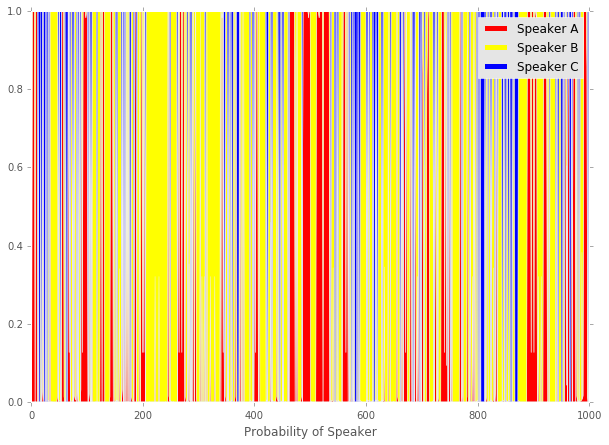

In [244]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
#Plotting:
plt.figure(figsize=(10,7))
plt.xlabel("Conversation Progress")
plt.xlabel("Probability of Speaker")
plt.plot([],[], label='Speaker A', linewidth=5, color = 'red')
plt.plot([],[], label='Speaker B', linewidth=5, color = 'yellow')
plt.plot([],[], label='Speaker C', linewidth=5, color = 'blue')
plt.stackplot(np.arange(len(node_posteriors)), node_posteriors.T, colors = ('red','yellow','blue'))
plt.legend()

plt.show()

# References

Davidson, G. (2017). Code Snippet. Retrieved on November 19, 2017 from https://minervaschools.slack.com/messages/C40KBD6VC/files/F82H1CV0U/ 